In [34]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [50]:
import torch
import pickle
import dataloaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn
import numpy as np
import random
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

In [36]:
from importlib import reload

In [37]:
config_file_path = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-06-13_10:12:01/config.pkl'
#
#config_file_path = 'train_results/biatt-augment-adj/experiment_2024-11-21_05:03:46/config.pkl'
#config_file_path = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-08-03_21:42:12/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [38]:
dconfig = config['data']
#dconfig['trigger_input_dir'] = '/ssd3/giorgian/hits-data-march-2024/trigger/1/'
dconfig['n_valid'] += dconfig['n_train'] + dconfig['n_test']
dconfig['n_train'] = 1
dconfig['n_test'] = 1
train_data, val_data, test_data = dataloaders.get_data_loaders(**dconfig)


KeyboardInterrupt: 

In [ ]:
DEVICE = 'cuda:1'
# α=0.7
#checkpoint_file = 'train_results/biatt-augment-adj/experiment_2024-11-21_05:03:46/checkpoints/model_checkpoint_016.pth.tar'
checkpoint_file = '/disks/disk1/giorgian/old-trainings/biatt-augment-adj/experiment_2023-06-13_10:12:01/checkpoints/model_checkpoint_016.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

In [ ]:
def efficiency_purity(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))
    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    p = preds_prob[keep]
    # Calculate efficiency
    tp = np.sum(c * (p > 0.5))
    tn = np.sum(( 1- c) * (p <= 0.5))
    fp = np.sum((1 - c) * (p > 0.5))
    fn = np.sum(c * (p <= 0.5))

    # effiency is how much of the signal we captured
    efficiency = tp/(tp + fn)
    # purity is how much of the signal is true
    purity = tp/(tp + fp)
    brr = tn/(tn + fp)

    return efficiency, purity, brr

def efficiency_purity_2(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))

    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    print(f'{np.sum(c)/c.shape[0]=}')
    p = preds_prob[keep]
    # Calculate efficiency
    cutoffs = np.unique(p)
    efficiencies = []
    purities = []
    brrs = []
    for cutoff in tqdm(cutoffs[::4]):
        tp = np.sum(c * (p > cutoff))
        tn = np.sum(( 1- c) * (p <= cutoff))
        fp = np.sum((1 - c) * (p > cutoff))
        fn = np.sum(c * (p <= cutoff))

        # effiency is how much of the signal we captured
        efficiency = tp/(tp + fn) if tp + fp != 0 else 0
        # purity is how much of the signal is true
        purity = tp/(tp + fp) if tp + fp != 0 else 1
        brr = tn / (tn + fp) if tn + fp != 0 else 0

        efficiencies.append(efficiency)
        purities.append(purity)
        brrs.append(brr)
        
    return np.array(efficiencies), np.array(purities), np.array(brrs)

In [ ]:
N_BATCHES = 10000
preds = []
preds_prob = []
correct = []
val_data.dataset.dataset.phi = 0
for batch in tqdm(val_data):
    track_vector = batch.track_vector.to(DEVICE)
    n_batches, n_tracks = track_vector.shape[:2]
    mask = torch.zeros((track_vector.shape[0], track_vector.shape[1])) 
    n_tracks = batch.n_tracks
    for i, n_track in enumerate(n_tracks):
        mask[i, :n_track] = 1
    mask = mask.to(DEVICE)


    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

    mask_logits = model(track_vector, mask)
    pred = mask_logits.max(dim=1)[1]
    preds.extend(pred.cpu().data.numpy())
    preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
    correct.extend(trigger.detach().cpu().numpy().flatten())

In [9]:
len(val_data)

2735

In [10]:
preds_prob = np.array(preds_prob)
preds = np.array(preds)
correct = np.array(correct)

In [60]:
f

array([[          nan,           nan,           nan],
       [0.0000000e+00, 0.0000000e+00, 3.9614353e-04],
       [0.0000000e+00, 0.0000000e+00, 3.5776109e-01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 6.7469280e-04],
       [0.0000000e+00, 0.0000000e+00, 3.2546656e-04],
       [1.0000000e+00, 1.0000000e+00, 9.9994900e-01]])

In [66]:
f = np.genfromtxt('results.csv', delimiter=',')
preds_prob_m = f[1:, 2]
preds_m = f[1:, 1]
correct_m = f[1:, 0]

In [70]:
preds_m

array([0., 0., 1., ..., 0., 0., 1.])

In [55]:
precision = precision_score(correct, preds).item()
print(f'{precision=}')
recall = recall_score(correct, preds).item()
print(f'{recall=}')
f1 = f1_score(correct, preds).item()
print(f'{f1=}')
roc = roc_auc_score(correct, preds).item()
print(f'{roc=}')

precision=0.8678464667032
recall=0.9547242210346015
f1=0.9092147124666599
roc=0.9046707857906219


In [ ]:
precision

In [71]:
fpr, tpr, thresholds = roc_curve(correct, preds_prob)
fpr_m, tpr_m, thresholds_m = roc_curve(correct_m, preds_prob_m)

Text(0.5, 1.0, 'ROC Curve for GNN')

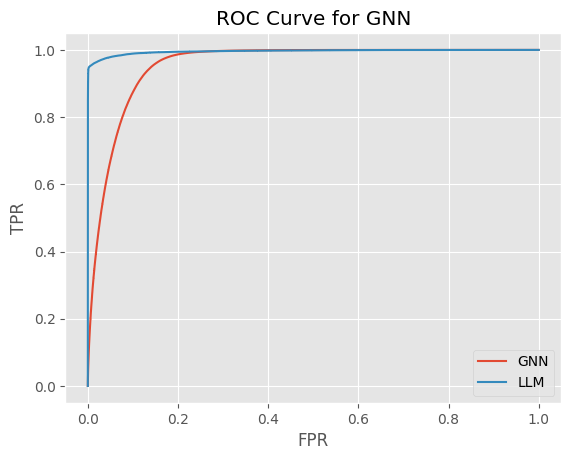

In [87]:
plt.style.use('ggplot')
plt.plot(fpr, tpr, label='GNN')
plt.plot(fpr_m, tpr_m, label='LLM')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curve for GNN')

In [12]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(np.float64(0.9530410183875531),
 np.float64(0.062098520805492836),
 np.float64(0.8546187791160298))

In [13]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(np.float64(0.9581329561527582),
 np.float64(0.06240959637372053),
 np.float64(0.8546187791160298))

In [88]:
efficiencies, purities, brrs = efficiency_purity_2(correct, preds_prob, signal_mix=0.01)
efficiencies_1, purities_1, brrs_1 = efficiency_purity_2(correct, preds_prob, signal_mix=0.005)

np.sum(c)/c.shape[0]=np.float64(0.009998995857558859)


  0%|          | 0/144863 [00:00<?, ?it/s]

np.sum(c)/c.shape[0]=np.float64(0.004999161357634062)


  0%|          | 0/144000 [00:00<?, ?it/s]

In [89]:
efficiencies_m, purities_m, brrs_m = efficiency_purity_2(correct_m, preds_prob_m, signal_mix=0.01)
efficiencies_m1, purities_m1, brrs_m1 = efficiency_purity_2(correct_m, preds_prob_m, signal_mix=0.005)

np.sum(c)/c.shape[0]=np.float64(0.009993549137593722)


  0%|          | 0/23384 [00:00<?, ?it/s]

np.sum(c)/c.shape[0]=np.float64(0.004995429713241077)


  0%|          | 0/23339 [00:00<?, ?it/s]

In [ ]:
efficiencei

In [97]:
preds_prob

array([9.3265998e-01, 2.1865028e-06, 2.1865028e-06, ..., 4.8782401e-02,
       9.3991387e-01, 9.5338148e-01], dtype=float32)

(array([488011.,  29282.,  14741.,   9963.,   7486.,   6177.,   5151.,
          4662.,   4111.,   3963.,   3839.,   3560.,   3511.,   3394.,
          3316.,   3247.,   3319.,   3529.,   3487.,   3580.,   3889.,
          3983.,   4216.,   4477.,   4607.,   4984.,   5219.,   5756.,
          6304.,   7016.,   7889.,   8742.,   9871.,  11037.,  12371.,
         13859.,  15750.,  18262.,  20623.,  23737.,  27667.,  32063.,
         38230.,  45752.,  54834.,  66165.,  79387.,  93205., 103086.,
         58690.]),
 array([7.92692689e-10, 1.99325401e-02, 3.98650803e-02, 5.97976223e-02,
        7.97301605e-02, 9.96626988e-02, 1.19595245e-01, 1.39527783e-01,
        1.59460321e-01, 1.79392859e-01, 1.99325398e-01, 2.19257936e-01,
        2.39190489e-01, 2.59123027e-01, 2.79055566e-01, 2.98988104e-01,
        3.18920642e-01, 3.38853180e-01, 3.58785719e-01, 3.78718257e-01,
        3.98650795e-01, 4.18583333e-01, 4.38515872e-01, 4.58448410e-01,
        4.78380978e-01, 4.98313516e-01, 5.18246055e-

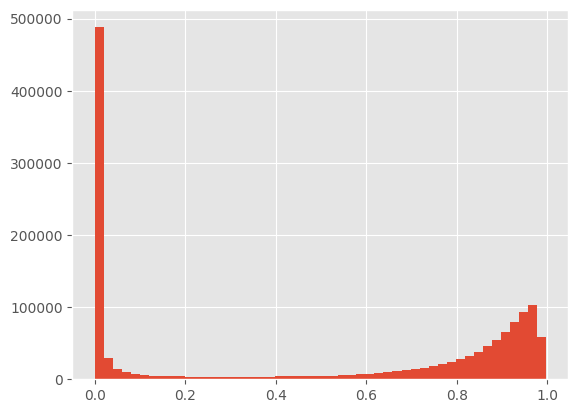

In [99]:
plt.hist(preds_prob, bins=50)

In [23]:
efficiencies_1, purities_1, brrs_1 = efficiency_purity_2(correct, preds_prob, signal_mix=0.001)

np.sum(c)/c.shape[0]=np.float64(0.000998999573284468)


  0%|          | 0/143311 [00:00<?, ?it/s]

In [12]:
for brr in [0.9, 0.95, 0.99, 0.999]:
    i = np.argmin(np.abs(brrs - brr))
    print(f'{efficiencies[i]*100:.2f}%, {purities[i]*100:.2f}%, {brrs[i]*100:.2f}%')

87.19%, 8.09%, 90.00%
66.73%, 11.88%, 95.00%
28.30%, 22.23%, 99.00%
6.17%, 38.41%, 99.90%


In [13]:
efficiencies, purities, brrs = efficiency_purity_2(correct, preds_prob, signal_mix=0.005)

np.sum(c)/c.shape[0]=np.float64(0.004999161357634062)


  0%|          | 0/143996 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
efficiencies

Text(0.5, 1.0, 'Track Efficiency/Purity Plot (1% Signal Mix)')

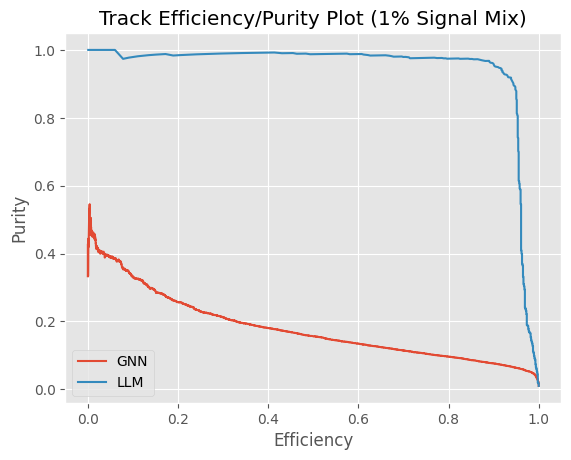

In [90]:
plt.style.use('ggplot')
plt.plot(efficiencies, purities, label='GNN')
plt.plot(efficiencies_m, purities_m, label='LLM')
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.legend()
plt.title('Track Efficiency/Purity Plot (1% Signal Mix)')

Text(0.5, 1.0, 'Track Efficiency/BRR Plot (1% Signal Mix)')

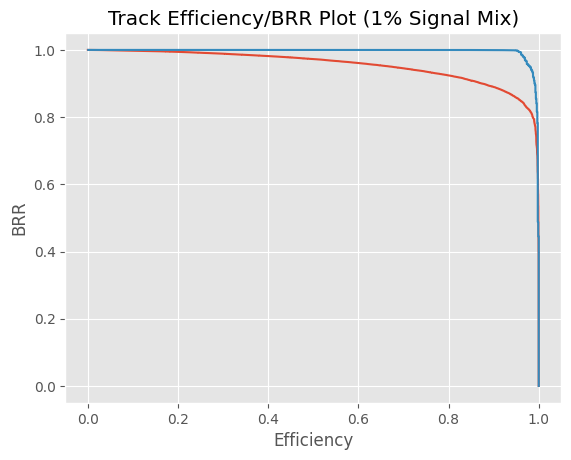

In [92]:
plt.style.use('ggplot')
plt.plot(efficiencies, brrs, label='GNN')
plt.plot(efficiencies_m, brrs_m, label='LLM')
plt.xlabel('Efficiency')
plt.ylabel('BRR')
plt.title('Track Efficiency/BRR Plot (1% Signal Mix)')

Text(0.5, 1.0, 'Track Efficiency/BRR Plot (0.5% Signal Mix)')

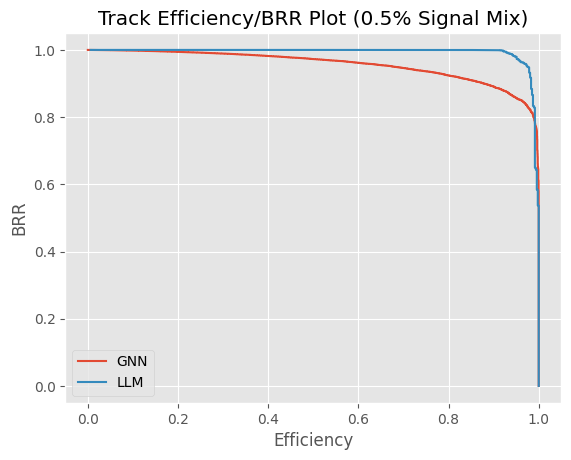

In [93]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, brrs_1, label='GNN')
plt.plot(efficiencies_m1, brrs_m1, label='LLM')
plt.legend()
plt.xlabel('Efficiency')
plt.ylabel('BRR')
plt.title('Track Efficiency/BRR Plot (0.5% Signal Mix)')

Text(0.5, 1.0, 'Track Efficiency/Purity Plot (0.5% Signal Mix)')

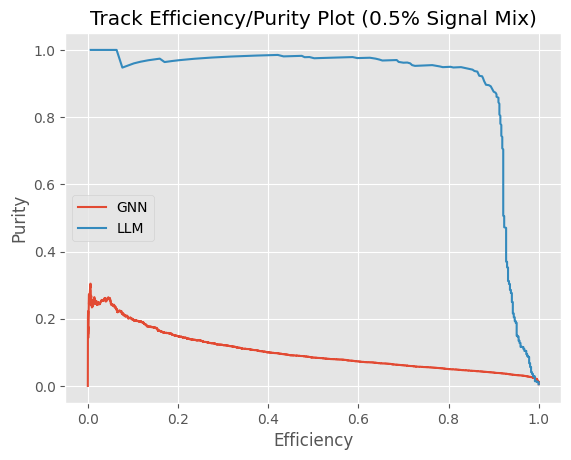

In [94]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, purities_1, label='GNN')
plt.plot(efficiencies_m1, purities_m1, label='LLM')
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.legend()
plt.title('Track Efficiency/Purity Plot (0.5% Signal Mix)')

Text(0.5, 1.0, 'Track Efficiency/Purity Plot (0.5% Signal Mix)')

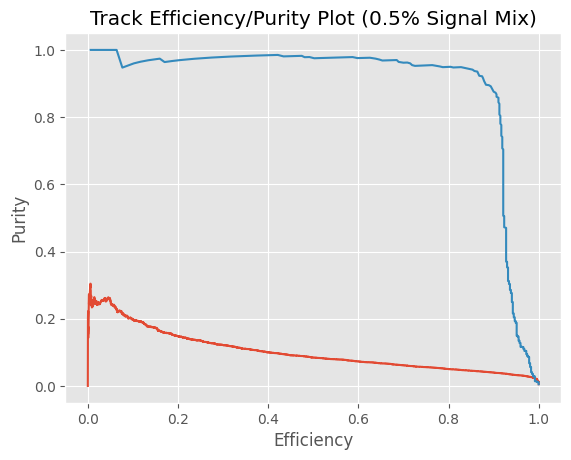

In [96]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, purities_1, label='GNN')
plt.plot(efficiencies_m1, purities_m1, label='LLM')
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.title('Track Efficiency/Purity Plot (0.5% Signal Mix)')

/tmp/ipykernel_1069934/2503319448.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies_m, 1/(1 - brrs_m), label='LLM')


5.71%	36.59%	99.90%


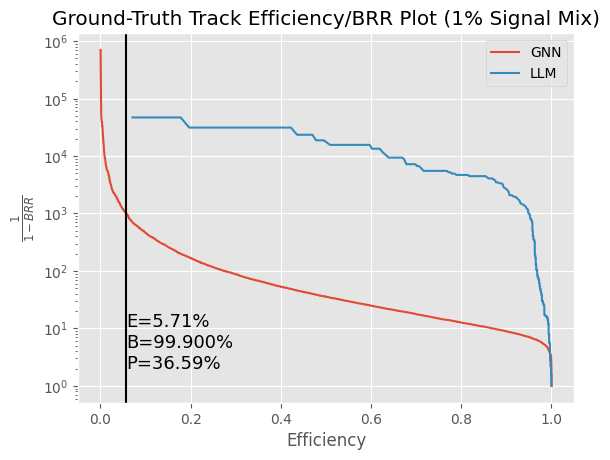

In [77]:
plt.style.use('ggplot')
plt.plot(efficiencies, 1/(1 - brrs), label='GNN')
plt.plot(efficiencies_m, 1/(1 - brrs_m), label='LLM')
plt.legend()
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Ground-Truth Track Efficiency/BRR Plot (1% Signal Mix)')
for brr in [0.999]:
    i = np.argmin(np.abs(brrs - brr))
    x, y, p = efficiencies[i], brrs[i], purities[i]
    plt.axvline(x, color='black')
    plt.text(x, 2, f'E={x*100:.2f}%\nB={y*100:.3f}%\nP={p*100:.2f}%', fontsize=13)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies[i]*100:.2f}%\t{purities[i]*100:.2f}%\t{brrs[i]*100:.2f}%')
plt.yscale('log')

/tmp/ipykernel_1069934/1747633883.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies_m1, 1/(1 - brrs_m1), label='LLM')


16.62%	26.71%	99.54%


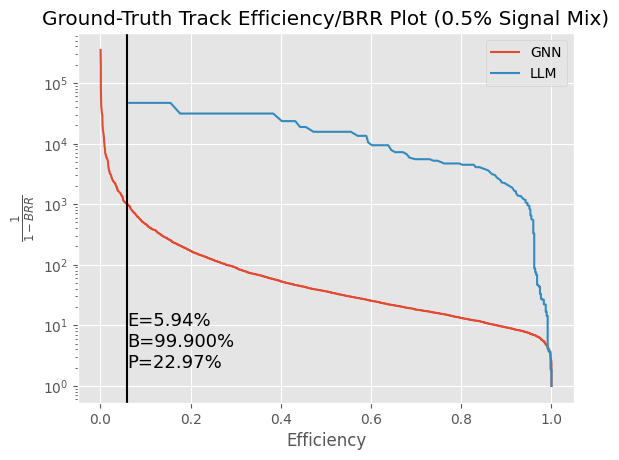

In [86]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, 1/(1 - brrs_1), label='GNN')
plt.plot(efficiencies_m1, 1/(1 - brrs_m1), label='LLM')
plt.legend()
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Ground-Truth Track Efficiency/BRR Plot (0.5% Signal Mix)')
for brr in [0.999]:
    i = np.argmin(np.abs(brrs_1 - brr))
    x, y, p = efficiencies_1[i], brrs_1[i], purities_1[i]
    plt.axvline(x, color='black')
    plt.text(x, 2, f'E={x*100:.2f}%\nB={y*100:.3f}%\nP={p*100:.2f}%', fontsize=13)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies[i]*100:.2f}%\t{purities[i]*100:.2f}%\t{brrs[i]*100:.2f}%')
plt.yscale('log')

In [94]:
np.sum(correct)*0.01

np.float64(550.0)

6.71%	6.29%	99.90000014%


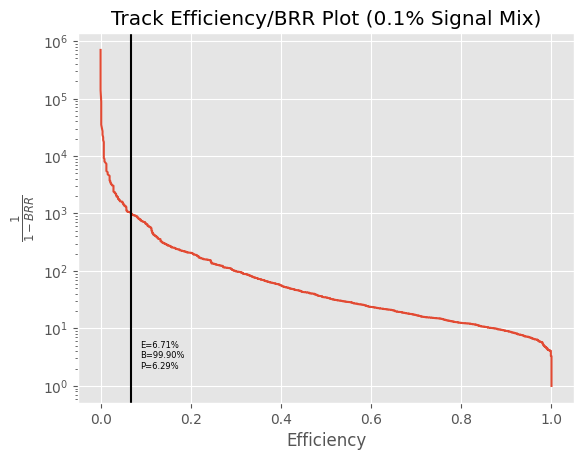

In [44]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, 1/(1 - brrs_1))
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Track Efficiency/BRR Plot (0.1% Signal Mix)')
for brr in [0.999]:
    i = np.argmin(np.abs(brrs_1 - brr))
    x, y, p = efficiencies_1[i], brrs_1[i], purities_1[i]
    plt.axvline(x, color='black')
    plt.text(x+0.02, 2, f'E={x*100:.2f}%\nB={y*100:.2f}%\nP={p*100:.2f}%', fontsize=6)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies_1[i]*100:.2f}%\t{purities_1[i]*100:.2f}%\t{brrs_1[i]*100:.8f}%')
plt.yscale('log')